<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/es4/AML_2022_HandsOn_4_LSTM_neural_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022 
## Hands-on session 4 

### Predict intracranial neurophysiological signal with LSTM networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
with np.load("encoded_neural_data.npz") as data:
    RT = data["RT"]# This is the reaction Time (time distance between the GO signal and the monkey movement)
    SSD = data["SSD"]#  This is the Stop Signal Delay (time distance between the GO signal and the STOP signal). If zero there is no stop
    encoded_trials = np.array(data["encoded"])# This is the neurophysiological signal encoded with a Variational AutoEncoder. The raw signal has 96 channels and it is noisy.

In [ ]:
# Go signal is at (-56+window-1), dt is 5 ms
# Absolute time vector in seconds with GO signal at zeros
window=8#see slide. This is a parameter used in the encoding. It is the length of sliding window that is used to encode the signal.
abs_time = np.arange(-56+window-1,200)*0.005

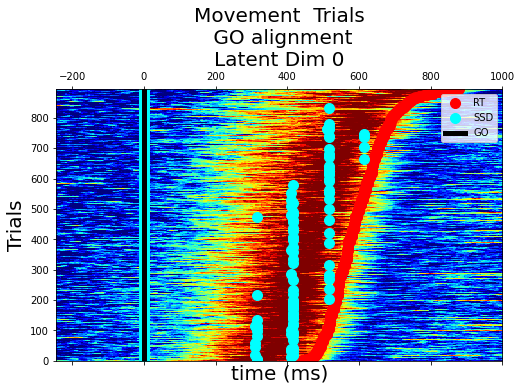

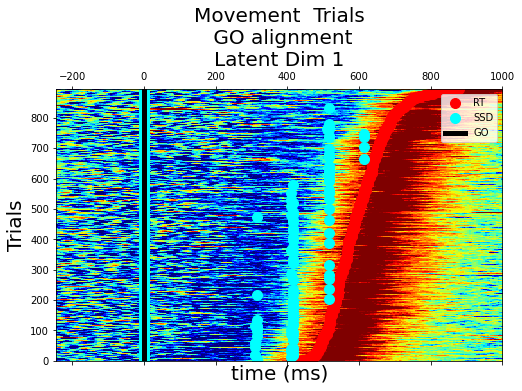

In [ ]:
def latent_plot(X,RT,SSD,el):
    f,ax=plt.subplots(figsize=(8,5))

    sorted_ind=np.argsort(RT)
    RT = RT[sorted_ind]
    SSD = SSD[sorted_ind]
    X=X[sorted_ind,:,:]
    min10=np.percentile(X[:,:,el].ravel(),10)
    max90=np.percentile(X[:,:,el].ravel(),90)

    extent = [(-56+window-1)*5 , 200*5, 0 , X.shape[0]]

    ax.matshow(X[:,:,el],vmin=min10, vmax=max90,origin='lower',aspect="auto",extent=extent,cmap='jet')

    ax.scatter(((RT)*5),np.arange(0,X.shape[0]),s=100,color='r',label="RT")
    if np.any(SSD !=0):
        ax.scatter(((SSD)*5),np.arange(0,X.shape[0]),s=100,color='cyan',label="SSD")

    ax.axvline(x=0, color='k', linestyle='-',label="GO",linewidth=5)
    ax.legend(loc='upper right')

    plt.ylabel('Trials',fontsize=20)
    plt.xlabel('time (ms)',fontsize=20)
    plt.title('Movement  Trials\n GO alignment\nLatent Dim {:}'.format(el),fontsize=20)
latent_plot(encoded_trials,RT,SSD,0)
latent_plot(encoded_trials,RT,SSD,1)

## Example: We wanto to know if at 100 the orange line will grow or decline. The blu line is the future (it is the signal shifted forward) and it is used as ground truth 

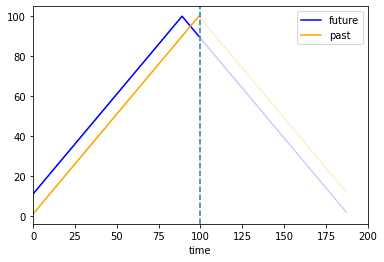

In [ ]:
def plot_example():
    test=np.concatenate([np.arange(1,100),np.arange(100,1,-1)],axis=0)
    X=test[:-10]
    target=test[10:]
    plt.plot(target,color="blue",alpha=0.2)
    plt.plot(X,color="orange",alpha=0.2)
    plt.plot(target[0:100],label="future",color="blue")
    plt.plot(X[0:100],label="past",color="orange")
    plt.axvline(100,linestyle='--')
    plt.legend()
    plt.xlim([0,200])
    plt.xlabel("time")
plot_example()

In [ ]:
# Mean RT for this session. Trial with RT >> mean RT may be more difficult to predict
mean_SSD_time = SSD[SSD>0].mean()*0.005
mean_SSD_index = int((SSD[SSD>0]+56-window+1).mean())

mean_RT_time = RT[RT>0].mean()*0.005
mean_RT_index = int((RT[RT>0]+56-window+1).mean())

In [ ]:
shift = 20# prediction at 100 ms in advance
trials = encoded_trials[:,:-shift,:]
target_trials = encoded_trials[:,shift:,:]
target_time = abs_time[:-shift]
time = abs_time[shift:]

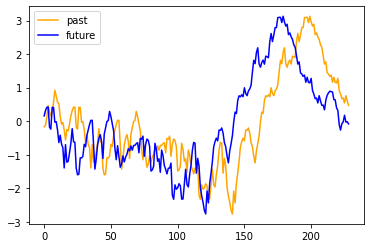

In [ ]:
plt.plot(trials[0,:,1],label="past",color="orange")
plt.plot(target_trials[0,:,1],label="future",color="blue")
plt.legend()

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, trials,target_trials, RT, SSD, sequence_length=5):
        self.SSD = SSD# not used in this notebook 
        self.RT = RT# not used in this notebook 
        self.L = trials.shape[1]
        self.N = trials.shape[0]
        self.D = trials.shape[-1]
        self.sequence_length = sequence_length
        self.y = torch.tensor(target_trials.reshape([-1,self.D])).float()
        self.X = torch.tensor(trials.reshape([-1,self.D])).float()# We concatenate all the trials in a long temporal series and we take a chunk each time.
        #be carefull because we don't want to predict the start of a new trial with the end of the previous one since other things happens in the mean time

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:# the start of the trial is padded to have the same length of other sequences
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        if (i%self.L < self.sequence_length)&(i>self.L): # or it is discarded and sobstituted with a sequence taken at random. 
            
            random_i = np.random.randint(1,self.N-1)*np.random.randint(self.sequence_length,self.L-self.sequence_length)
            i_start = random_i - self.sequence_length + 1
            x = self.X[i_start:(random_i + 1), :]
            return x, self.y[random_i]
        
        return x, self.y[i]



In [ ]:
#We split the dataset. Since trials happes one after the other (they are repetitions of the same action many time) we use the first ones to train and the last to test.
#A random split may also work.
N=trials.shape[0]
N_train = int(0.75*N)
N_vali = int(0.85*N)
print("dataset with {} trials:\n train {}, vali {}, test {}".format(N,RT[:N_train].shape[0],RT[N_train:N_vali].shape[0],RT[N_vali:].shape[0]))

sequence_length = 50# the number of previous points that we want to use to predict 
i=100# we select a intem of the generator. If i is longer than a trial "reset" the time
train_dataset = SequenceDataset(
    trials[:N_train],
    target_trials[:N_train],
    RT[:N_train],
    SSD[:N_train],
    sequence_length=sequence_length
)

X,y = train_dataset[i]
print(X)
print(y)
print(X.shape)

vali_dataset = SequenceDataset(
    trials[N_train:N_vali],
    target_trials[N_train:N_vali],
    RT[N_train:N_vali],
    SSD[N_train:N_vali],
    sequence_length=sequence_length
)



dataset with 895 trials:
 train 671, vali 89, test 135
tensor([[-0.7104, -0.7621,  0.0031,  1.7492,  1.2615, -0.4836],
        [-0.4415, -0.4285, -0.3508,  2.0666,  1.1625, -0.8478],
        [-1.0073, -0.2630, -0.4631,  2.8452,  1.2292, -1.3617],
        [-0.4216, -0.0947, -0.7518,  1.8223,  0.8910, -0.6698],
        [-1.0198,  0.0253, -0.7844,  2.8648,  1.1197, -1.3567],
        [-1.0458,  0.0244, -0.5749,  2.5204,  1.0469, -1.1847],
        [-1.3050, -0.7058, -0.7505,  2.1807,  1.4476, -0.2515],
        [-0.9239, -1.4308, -1.0363,  1.2295,  1.8641,  0.7941],
        [-0.9938, -1.1329, -0.6578,  1.6510,  1.7696, -0.1845],
        [-0.9005, -0.7122, -0.2559,  1.2024,  1.1528,  0.1536],
        [-0.4759, -0.5078, -0.9157,  0.8283,  0.9857,  0.9067],
        [-1.0592, -0.4008, -0.7392,  1.4956,  1.2470,  0.0399],
        [-0.8584, -0.6050, -0.5081,  1.4039,  1.2182,  0.0488],
        [-0.6526, -1.1153, -0.2662, -0.0083,  1.3498,  0.9455],
        [-0.7560, -0.3869,  0.0220,  1.4350,  0.8

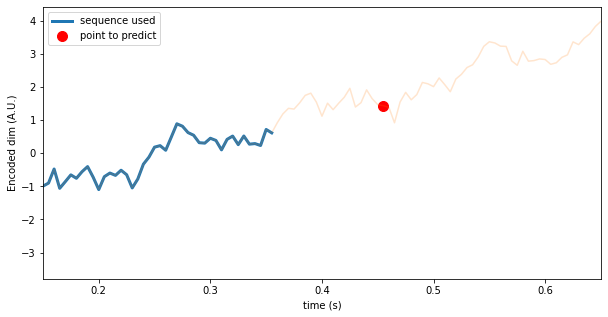

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(time[i-sequence_length+1:i+1],X[:,0],linewidth=3,label="sequence used")
plt.plot(time,trials[0,:,0],alpha=0.2)
plt.scatter(time[i+shift],y[0],100,color="red", label="point to predict")
plt.xlim([0.15,0.65])
plt.xlabel("time (s)")
plt.ylabel("Encoded dim (A.U.)")
plt.legend()

In [ ]:
# we can use the dataloader to batch the datasets
torch.manual_seed(99)
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=batch_size, shuffle=True)


In [ ]:


class CNN_RegressionLSTM(nn.Module):
    def __init__(self, encoded_dim, hidden_units,num_layers=1):
        super().__init__()
        self.encoded_dim = encoded_dim  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.encoded_dim,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=0.2
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=self.encoded_dim)
        self.relu = nn.ReLU()
        
        # we can filter the signal with 1D CNN before the recurrent network to extract more usefull features.
        # Our variables are already very informative since they are the latent space encoding of a VAE so there is no need for a complex feature extraction.
        self.c1 = nn.Conv1d(encoded_dim, hidden_units, 3,dilation=2)
        self.p1 = nn.AvgPool1d(2)
        self.c2 = nn.Conv1d(hidden_units, encoded_dim, 3)
        

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        x=x.permute((0, 2, 1))# remenber that for the CNN the input shape is [batch, ch, time]
        
        x=self.c1(x)
        x=self.p1(x)
        x=self.c2(x)
        
        x=x.permute((0, 2, 1))# for the LSTM 
        _, (hn, _) = self.lstm(x, (h0, c0))
        hn = hn[-1].view(-1, self.hidden_units)
        out =self.relu(hn)
        out = self.linear(out)  

        return  out


In [ ]:
learning_rate = 5e-5
num_hidden_units = 32
num_layers=2

model = CNN_RegressionLSTM(encoded_dim=encoded_trials.shape[2], hidden_units=num_hidden_units,num_layers=num_layers)
loss_function = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

In [ ]:
print("Untrained test\n--------")
test_model(vali_loader, model, loss_function)
print()

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(vali_loader, model, loss_function)
    print()


Untrained test
--------
Test loss: 0.21837736163288354

Epoch 0
---------
Train loss: 0.2110358031961344
Test loss: 0.2186377665027976

Epoch 1
---------
Train loss: 0.2108243039927812
Test loss: 0.21741692358627915

Epoch 2
---------
Train loss: 0.21010564531910728
Test loss: 0.21879382347688078

Epoch 3
---------
Train loss: 0.20963685594182724
Test loss: 0.21658736066892742

Epoch 4
---------
Train loss: 0.20882962415805964
Test loss: 0.21618352634832264

Epoch 5
---------
Train loss: 0.20931556240208044
Test loss: 0.21491114040836692

Epoch 6
---------
Train loss: 0.20841982822980015
Test loss: 0.2154612279497087

Epoch 7
---------
Train loss: 0.2074955472293047
Test loss: 0.21550796497613192

Epoch 8
---------
Train loss: 0.2069534398460269
Test loss: 0.2170369961299002

Epoch 9
---------
Train loss: 0.2066099589115178
Test loss: 0.21532608084380628



In [ ]:
def batch_a_trial(trial,sequence_length=40,shift=10):
    X = []
    Y = []
    for i in range(sequence_length+1,trial.shape[0]-shift,1):
        #
        x=trial[(i-sequence_length):i,:]
        y=trial[i+shift,:]
       # print(x.shape)
        X.append(x)
        Y.append(y)
    X=np.array(X)
    print(X.shape)
    Y=np.array(Y)
    X=torch.from_numpy(X).float()
    #Y=torch.from_numpy(Y).float()
    return X,Y
        
def predict(X, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        y_star = model(X)
    
    return y_star.numpy()    

mean_target = np.mean(target_trials,axis=0)
mean_target[sequence_length+1:]

array([[-6.8774962e-01, -8.1340188e-01,  3.0340189e-01,  8.1630749e-01,
         1.0725554e+00,  1.0984295e-01],
       [-6.4754891e-01, -8.3927423e-01,  3.1327850e-01,  8.3077681e-01,
         1.0753282e+00,  9.9497579e-02],
       [-6.0316485e-01, -8.5073459e-01,  3.1513759e-01,  8.0981463e-01,
         1.0693129e+00,  1.2045458e-01],
       ...,
       [-1.0446802e+00,  1.3938899e-01,  1.0650860e-03, -7.3355627e-01,
         3.6326051e-01,  1.0485578e+00],
       [-1.0293477e+00,  1.3781346e-01,  2.2341652e-02, -7.4049962e-01,
         3.5479707e-01,  1.0566616e+00],
       [-1.0390475e+00,  1.2101817e-01,  1.8742334e-02, -7.1293354e-01,
         3.7766078e-01,  1.0539794e+00]], dtype=float32)

(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)
(178, 50, 6)


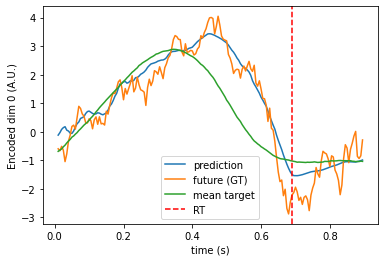

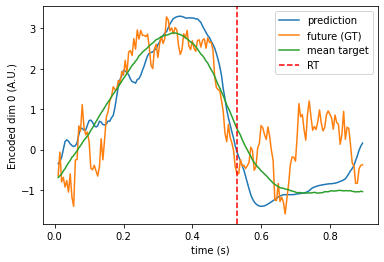

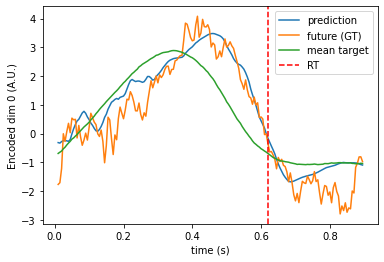

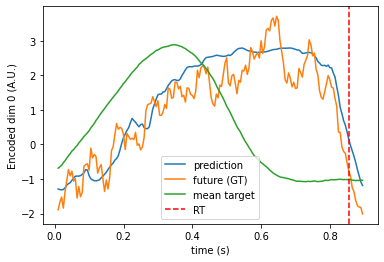

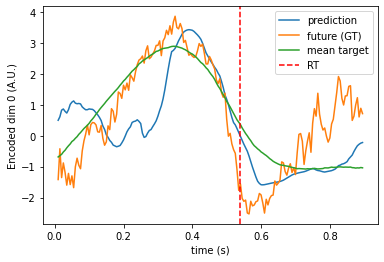

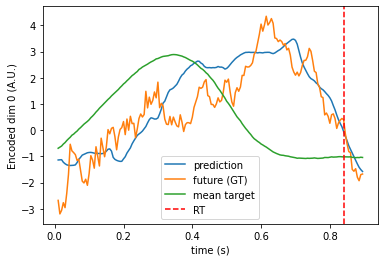

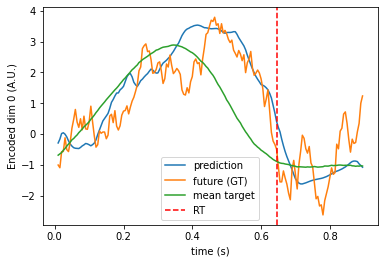

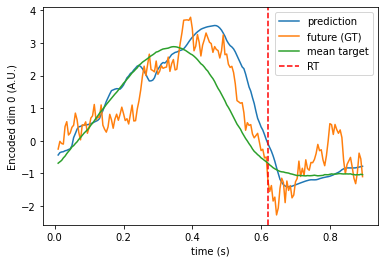

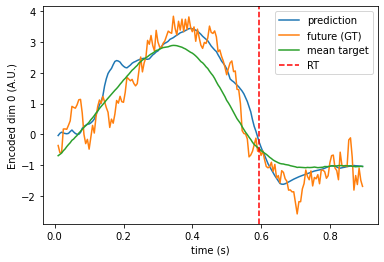

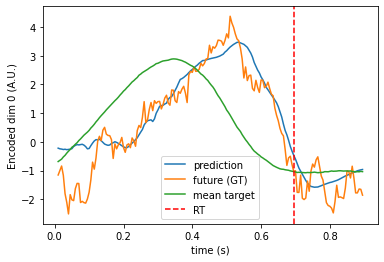

In [ ]:
for i in range(10):
    dim=0
    X,Y = batch_a_trial(encoded_trials[-i,:,:],sequence_length=sequence_length,shift=shift)
    #print(X.shape)
    #print(y_pred.shape)
   # print(Y.shape)
    y_pred=predict(X, model)
    #plt.plot(y_pred[:,0])
    #plt.plot(X[:,-1,0],label="past")
    #plt.plot(Y[:,0],label="future")
    plt.figure()
    plt.plot(target_time[sequence_length+1:],y_pred[:,dim],label="prediction")
    plt.plot(target_time[sequence_length+1:],Y[:,dim],label="future (GT)")
    plt.plot(target_time[sequence_length+1:],mean_target[sequence_length+1:,dim],label="mean target")
    plt.axvline(RT[-i]*0.005,linestyle='--',color="red",label="RT")
    plt.xlabel("time (s)")
    plt.ylabel("Encoded dim {} (A.U.)".format(dim))
    plt.legend()